<a href="https://colab.research.google.com/github/AmoghTantradi/CS182-final-project/blob/main/Milestone_2_sd_dreambooth_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Dreambooth fine-tuning one multiple objects for Stable Diffusion

This notebook shows how to "teach" Stable Diffusion a new concept via Dreambooth using 🤗 Hugging Face [🧨 Diffusers library](https://github.com/huggingface/diffusers).

![Dreambooth Example](https://dreambooth.github.io/DreamBooth_files/teaser_static.jpg)

_By using just 3-5 images for each object you can teach new concepts to Stable Diffusion and personalize the model on your own images_

We will be using the images of Oski and Teedy bear as new concepts to train the Stable Diffusion on learning both concepts on the same model.

## Initial setup

In [ ]:
#@title Install the required libs
!pip install -U -qq git+https://github.com/huggingface/diffusers.git
!pip install -qq accelerate tensorboard transformers ftfy gradio
!pip install -qq "ipywidgets>=7,<8"
!pip install -qq bitsandbytes

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 261.4/261.4 kB 6.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.4/53.4 kB 8.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.5/16.5 MB 93.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 92.9/92.9 kB 13.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 302.7/302.7 kB 38.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.0/75.0 kB 10.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 138.7/138.7 kB 17.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 381.9/381.9 kB 39.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.7/45.7 kB 6.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 59.7/59.7 kB 8.5 MB/s eta 0:00:00
     ━━━━━

In [ ]:
#@title Install xformers for faster and memory efficient training
%%time

!pip install -U --pre triton

from subprocess import getoutput
from IPython.display import HTML
from IPython.display import clear_output
import time

s = getoutput('nvidia-smi')
if 'T4' in s:
  gpu = 'T4'
elif 'P100' in s:
  gpu = 'P100'
elif 'V100' in s:
  gpu = 'V100'
elif 'A100' in s:
  gpu = 'A100'

while True:
    try:
        gpu=='T4'or gpu=='P100'or gpu=='V100'or gpu=='A100'
        break
    except:
        pass
    print('[1;31mit seems that your GPU is not supported at the moment')
    time.sleep(5)

if (gpu=='T4'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='P100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/P100/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='V100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/V100/xformers-0.0.13.dev0-py3-none-any.whl

elif (gpu=='A100'):
  %pip install -q https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/A100/xformers-0.0.13.dev0-py3-none-any.whl

  ERROR: HTTP error 404 while getting https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl
ERROR: Could not install requirement xformers==0.0.13.dev0 from https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl because of HTTP error 404 Client Error: Not Found for url: https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl for URL https://github.com/TheLastBen/fast-stable-diffusion/raw/main/precompiled/T4/xformers-0.0.13.dev0-py3-none-any.whl
CPU times: user 70.5 ms, sys: 6.87 ms, total: 77.4 ms
Wall time: 9.15 s


In [ ]:
#@title Import required libraries
import argparse
import itertools
import math
import os
from contextlib import nullcontext
import random

import numpy as np
import torch
import torch.nn.functional as F
import torch.utils.checkpoint
from torch.utils.data import Dataset

import PIL
from accelerate import Accelerator
from accelerate.logging import get_logger
from accelerate.utils import set_seed
from diffusers import AutoencoderKL, DDPMScheduler, PNDMScheduler, StableDiffusionPipeline, UNet2DConditionModel
from diffusers.optimization import get_scheduler
from diffusers.pipelines.stable_diffusion import StableDiffusionSafetyChecker
from PIL import Image
from torchvision import transforms
from tqdm.auto import tqdm
from transformers import CLIPFeatureExtractor, CLIPTextModel, CLIPTokenizer

import bitsandbytes as bnb

def image_grid(imgs, rows, cols):
    assert len(imgs) == rows*cols

    w, h = imgs[0].size
    grid = Image.new('RGB', size=(cols*w, rows*h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i%cols*w, i//cols*h))
    return grid

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_runtime.py:184: UserWarning: Pydantic is installed but cannot be imported. Please check your installation. `huggingface_hub` will default to not using Pydantic. Error message: '{e}'
  warnings.warn(


## Settings for teaching your new concept

In [ ]:
#@title Determine the pretrained model
#@markdown `pretrained_model_name_or_path` which Stable Diffusion checkpoint you want to use
pretrained_model_name_or_path = "stabilityai/stable-diffusion-2" #@param ["stabilityai/stable-diffusion-2", "stabilityai/stable-diffusion-2-base", "CompVis/stable-diffusion-v1-4", "runwayml/stable-diffusion-v1-5"] {allow-input: true}

In [ ]:
#@title prepare the URL for our input data
oski_urls = [
      "https://huggingface.co/datasets/FanjiaYan/CS182-DreamBooth-dataset/resolve/main/oski-1.jpeg",
      "https://huggingface.co/datasets/FanjiaYan/CS182-DreamBooth-dataset/resolve/main/oski-2.jpeg",
      "https://huggingface.co/datasets/FanjiaYan/CS182-DreamBooth-dataset/resolve/main/oski-3.jpeg",
      "https://huggingface.co/datasets/FanjiaYan/CS182-DreamBooth-dataset/resolve/main/oski-4.jpeg",
      ]
teddy_urls = [
      "https://huggingface.co/datasets/FanjiaYan/CS182-DreamBooth-dataset/resolve/main/teddy-1.png",
      "https://huggingface.co/datasets/FanjiaYan/CS182-DreamBooth-dataset/resolve/main/teddy-2.png",
      "https://huggingface.co/datasets/FanjiaYan/CS182-DreamBooth-dataset/resolve/main/teddy-3.png",
      "https://huggingface.co/datasets/FanjiaYan/CS182-DreamBooth-dataset/resolve/main/teddy-4.png",
      ]

In [ ]:
#@title Setup and check the images you have just added
import requests
import glob
from io import BytesIO

def download_image(url):
  try:
    response = requests.get(url)
  except:
    return None
  return Image.open(BytesIO(response.content)).convert("RGB")

oski_images = list(filter(None,[download_image(url) for url in oski_urls]))
teddy_images = list(filter(None,[download_image(url) for url in teddy_urls]))
save_path = "./my_concept"
save_path2 = "./my_concept2"
if not os.path.exists(save_path):
  os.mkdir(save_path)
[image.save(f"{save_path}/{i}.jpeg") for i, image in enumerate(oski_images)]
if not os.path.exists(save_path2):
  os.mkdir(save_path2)
_ =[image.save(f"{save_path2}/{i}.jpeg") for i, image in enumerate(teddy_images)]

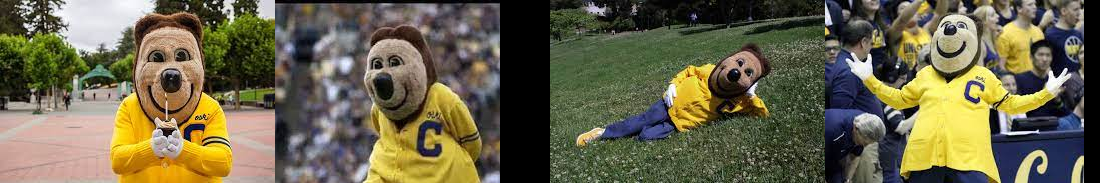

In [ ]:
#@title Oski image input
image_grid(oski_images,1,len(oski_images))

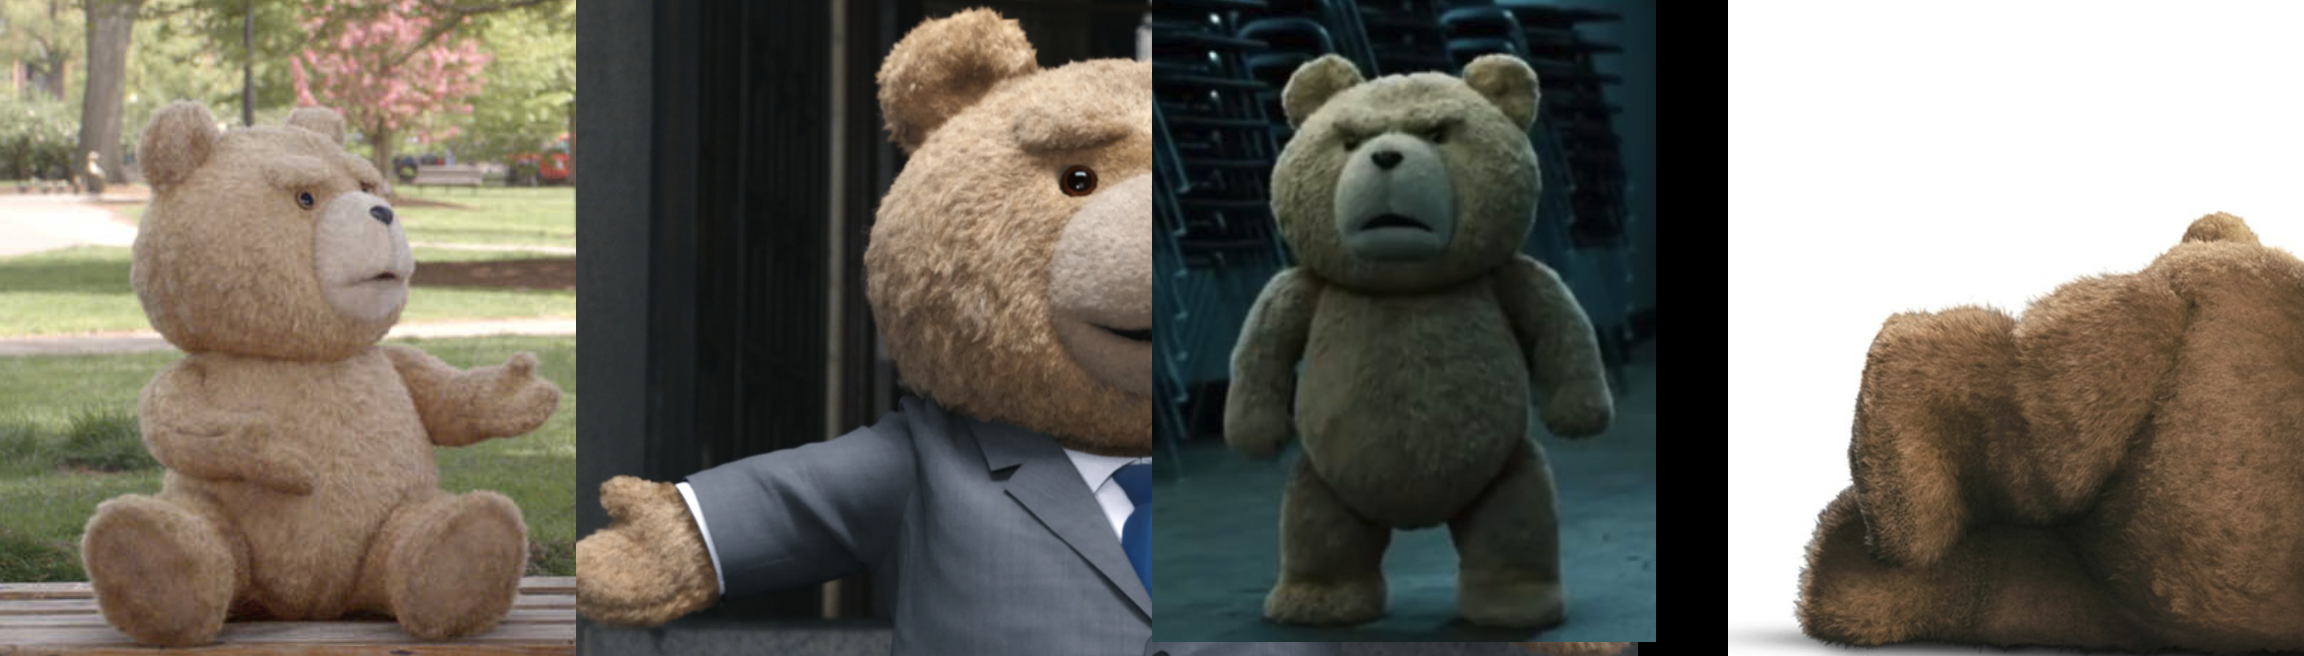

In [ ]:
#@title Teddy image input
image_grid(teddy_images,1,len(teddy_images))

In [ ]:
#@title Settings for your newly created concept
#@markdown `instance_prompt` is a prompt that should contain a good description of what your object or style is, together with the initializer word `Zephon`, and `Therewith` which are genereated from our rare tokenizes in another notebook
instance_prompt = "Zephon bear" #@param {type:"string"}
instance_prompt2 = "Therewith bear" #@param {type:"string"}


prior_preservation = True
#@markdown The prior perservation we want to utilize is the concept of `bear` since this is the concept we want to retain on our new fine-tuned model
prior_preservation_class_prompt = "bear" #@param {type:"string"}

num_class_images = 12
sample_batch_size = 2
prior_loss_weight = 0.5
prior_preservation_class_folder = "./class_images"
class_data_root=prior_preservation_class_folder
class_prompt=prior_preservation_class_prompt

## Teach the model the new concepts (fine-tuning with Dreambooth)
Below is the prior perservation and training function. We frist generate the prior preservation class using the `prior_preservation_class_prompt`. In our case, it is `bear`. After generated `num_class_images` images, we use those images to calculate a seperate loss for each epoch. We call it `prior_preservation_loss`.

The total loss for each step is calculated by:

$total\_loss = prior\_preservation\_loss * prior\_preservation\_weight + original\_loss$

In [ ]:
#@title Setup the DreamBooth Classes
from pathlib import Path
from torchvision import transforms

class DreamBoothDataset(Dataset):
    def __init__(
        self,
        instance_data_root,
        instance_data_root2,
        instance_prompt,
        instance_prompt2,
        tokenizer,
        class_data_root=None,
        class_prompt=None,
        size=512,
        center_crop=False,
    ):
        self.size = size
        self.center_crop = center_crop
        self.tokenizer = tokenizer

        self.instance_data_root = Path(instance_data_root)
        if not self.instance_data_root.exists():
            raise ValueError("Instance images root doesn't exists.")

        self.instance_data_root2 = Path(instance_data_root2)
        if not self.instance_data_root2.exists():
            raise ValueError("Instance images root doesn't exists.")



        self.instance_images_path = list(Path(instance_data_root).iterdir())
        self.num_instance_images = len(self.instance_images_path)
        self.instance_prompt = instance_prompt

        self.instance_images_path2 = list(Path(instance_data_root2).iterdir())
        self.num_instance_images2 = len(self.instance_images_path2)
        self.instance_prompt2 = instance_prompt2

        self._length = max(self.num_instance_images, self.num_instance_images2) # TODO






        if class_data_root is not None:
            self.class_data_root = Path(class_data_root)
            self.class_data_root.mkdir(parents=True, exist_ok=True)
            self.class_images_path = list(Path(class_data_root).iterdir())
            self.num_class_images = len(self.class_images_path)
            self._length = max(self.num_class_images, self.num_instance_images)
            self.class_prompt = class_prompt
        else:
            self.class_data_root = None

        self.image_transforms = transforms.Compose(
            [
                transforms.Resize(size, interpolation=transforms.InterpolationMode.BILINEAR),
                transforms.CenterCrop(size) if center_crop else transforms.RandomCrop(size),
                transforms.ToTensor(),
                transforms.Normalize([0.5], [0.5]),
            ]
        )

    def __len__(self):
        return self._length

    def __getitem__(self, index):
        example = {}

        instance_image = Image.open(self.instance_images_path[index % self.num_instance_images])
        if not instance_image.mode == "RGB":
            instance_image = instance_image.convert("RGB")
        example["instance_images"] = self.image_transforms(instance_image)
        example["instance_prompt_ids"] = self.tokenizer(
            self.instance_prompt,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids

        instance_image2 = Image.open(self.instance_images_path2[index % self.num_instance_images2])
        if not instance_image2.mode == "RGB":
            instance_image2 = instance_image2.convert("RGB")
        example["instance_images2"] = self.image_transforms(instance_image2)
        example["instance_prompt_ids2"] = self.tokenizer(
            self.instance_prompt2,
            padding="do_not_pad",
            truncation=True,
            max_length=self.tokenizer.model_max_length,
        ).input_ids



        if self.class_data_root:
            class_image = Image.open(self.class_images_path[index % self.num_class_images])
            if not class_image.mode == "RGB":
                class_image = class_image.convert("RGB")
            example["class_images"] = self.image_transforms(class_image)
            example["class_prompt_ids"] = self.tokenizer(
                self.class_prompt,
                padding="do_not_pad",
                truncation=True,
                max_length=self.tokenizer.model_max_length,
            ).input_ids

        return example


class PromptDataset(Dataset):
    def __init__(self, prompt, num_samples):
        self.prompt = prompt
        self.num_samples = num_samples

    def __len__(self):
        return self.num_samples

    def __getitem__(self, index):
        example = {}
        example["prompt"] = self.prompt
        example["index"] = index
        return example

In [ ]:
#@title Generate Class Images using prior preservation prompt from pretrained Stable Diffusion
import gc
if(prior_preservation):
    class_images_dir = Path(class_data_root)
    if not class_images_dir.exists():
        class_images_dir.mkdir(parents=True)
    cur_class_images = len(list(class_images_dir.iterdir()))

    if cur_class_images < num_class_images:
        pipeline = StableDiffusionPipeline.from_pretrained(
            pretrained_model_name_or_path, revision="fp16", torch_dtype=torch.float16
        ).to("cuda")
        pipeline.enable_attention_slicing()
        pipeline.set_progress_bar_config(disable=True)

        num_new_images = num_class_images - cur_class_images
        print(f"Number of class images to sample: {num_new_images}.")

        sample_dataset = PromptDataset(class_prompt, num_new_images)
        sample_dataloader = torch.utils.data.DataLoader(sample_dataset, batch_size=sample_batch_size)

        for example in tqdm(sample_dataloader, desc="Generating class images"):
            images = pipeline(example["prompt"]).images

            for i, image in enumerate(images):
                image.save(class_images_dir / f"{example['index'][i] + cur_class_images}.jpg")
        pipeline = None
        gc.collect()
        del pipeline
        with torch.no_grad():
          torch.cuda.empty_cache()

model_index.json:   0%|          | 0.00/511 [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/diffusers/pipelines/pipeline_utils.py:263: FutureWarning: You are loading the variant fp16 from stabilityai/stable-diffusion-2 via `revision='fp16'` even though you can load it via `variant=`fp16`. Loading model variants via `revision='fp16'` is deprecated and will be removed in diffusers v1. Please use `variant='fp16'` instead.
  warnings.warn(
vae/diffusion_pytorch_model.safetensors not found


Fetching 12 files:   0%|          | 0/12 [00:00<?, ?it/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/815 [00:00<?, ?B/s]

tokenizer/merges.txt:   0%|          | 0.00/525k [00:00<?, ?B/s]

tokenizer/special_tokens_map.json:   0%|          | 0.00/460 [00:00<?, ?B/s]

text_encoder/config.json:   0%|          | 0.00/624 [00:00<?, ?B/s]

scheduler/scheduler_config.json:   0%|          | 0.00/345 [00:00<?, ?B/s]

tokenizer/vocab.json:   0%|          | 0.00/1.06M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/900 [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/602 [00:00<?, ?B/s]

pytorch_model.bin:   0%|          | 0.00/681M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/167M [00:00<?, ?B/s]

diffusion_pytorch_model.bin:   0%|          | 0.00/1.73G [00:00<?, ?B/s]

Loading pipeline components...:   0%|          | 0/5 [00:00<?, ?it/s]

Number of class images to sample: 12.


Generating class images:   0%|          | 0/6 [00:00<?, ?it/s]

In [ ]:
#@title Load the Stable Diffusion model
# Load models and create wrapper for stable diffusion
text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
)
vae = AutoencoderKL.from_pretrained(
    pretrained_model_name_or_path, subfolder="vae"
)
unet = UNet2DConditionModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="unet"
)
tokenizer = CLIPTokenizer.from_pretrained(
    pretrained_model_name_or_path,
    subfolder="tokenizer",
)

text_encoder/config.json:   0%|          | 0.00/633 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/1.36G [00:00<?, ?B/s]

vae/config.json:   0%|          | 0.00/611 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/335M [00:00<?, ?B/s]

unet/config.json:   0%|          | 0.00/909 [00:00<?, ?B/s]

diffusion_pytorch_model.safetensors:   0%|          | 0.00/3.46G [00:00<?, ?B/s]

tokenizer/tokenizer_config.json:   0%|          | 0.00/824 [00:00<?, ?B/s]

In [ ]:
#@title Setting up all training arguments
from argparse import Namespace
args = Namespace(
    pretrained_model_name_or_path=pretrained_model_name_or_path,
    resolution=vae.sample_size,
    center_crop=True,
    train_text_encoder=False,
    instance_data_dir="./my_concept",
    instance_data_dir2="./my_concept2",
    instance_prompt=instance_prompt,
    instance_prompt2=instance_prompt2,
    learning_rate=5e-06,
    max_train_steps=300,
    save_steps=300,
    train_batch_size=1, # set to 1 if using prior preservation
    gradient_accumulation_steps=2,
    max_grad_norm=1.0,
    mixed_precision="fp16", # set to "fp16" for mixed-precision training.
    gradient_checkpointing=True, # set this to True to lower the memory usage.
    use_8bit_adam=True, # use 8bit optimizer from bitsandbytes
    seed=3434554,
    with_prior_preservation=prior_preservation,
    prior_loss_weight=prior_loss_weight,
    sample_batch_size=2,
    class_data_dir=prior_preservation_class_folder,
    class_prompt=prior_preservation_class_prompt,
    num_class_images=num_class_images,
    lr_scheduler="constant",
    lr_warmup_steps=100,
    output_dir="dreambooth-concept",
)

<ipython-input-20-ccd2aad3eb7a>:5: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  resolution=vae.sample_size,


In [ ]:
#@title Training function
instance_loss = []
class_loss = []
from accelerate.utils import set_seed
def training_function(text_encoder, vae, unet):
    logger = get_logger(__name__)

    set_seed(args.seed)

    accelerator = Accelerator(
        gradient_accumulation_steps=args.gradient_accumulation_steps,
        mixed_precision=args.mixed_precision,
    )

    if args.train_text_encoder and args.gradient_accumulation_steps > 1 and accelerator.num_processes > 1:
        raise ValueError(
            "Gradient accumulation is not supported when training the text encoder in distributed training. "
            "Please set gradient_accumulation_steps to 1. This feature will be supported in the future."
        )

    vae.requires_grad_(False)
    if not args.train_text_encoder:
        text_encoder.requires_grad_(False)

    if args.gradient_checkpointing:
        unet.enable_gradient_checkpointing()
        if args.train_text_encoder:
            text_encoder.gradient_checkpointing_enable()

    # Use 8-bit Adam for lower memory usage or to fine-tune the model in 16GB GPUs
    if args.use_8bit_adam:
        optimizer_class = bnb.optim.AdamW8bit
    else:
        optimizer_class = torch.optim.AdamW

    params_to_optimize = (
        itertools.chain(unet.parameters(), text_encoder.parameters()) if args.train_text_encoder else unet.parameters()
    )

    optimizer = optimizer_class(
        params_to_optimize,
        lr=args.learning_rate,
    )

    noise_scheduler = DDPMScheduler.from_config(args.pretrained_model_name_or_path, subfolder="scheduler")

    train_dataset = DreamBoothDataset(
        instance_data_root=args.instance_data_dir,
        instance_data_root2=args.instance_data_dir2,
        instance_prompt=args.instance_prompt,
        instance_prompt2=args.instance_prompt2,
        class_data_root=args.class_data_dir if args.with_prior_preservation else None,
        class_prompt=args.class_prompt,
        tokenizer=tokenizer,
        size=args.resolution,
        center_crop=args.center_crop,
    )

    def collate_fn(examples): # examples = [{instaces_images}]
        input_ids = [example["instance_prompt_ids"] for example in examples]
        pixel_values = [example["instance_images"] for example in examples]

        input_ids += [example["instance_prompt_ids2"] for example in examples]
        pixel_values += [example["instance_images2"] for example in examples]

        # concat class and instance examples for prior preservation
        if args.with_prior_preservation:
            input_ids += [example["class_prompt_ids"] for example in examples]
            pixel_values += [example["class_images"] for example in examples]

        pixel_values = torch.stack(pixel_values)
        pixel_values = pixel_values.to(memory_format=torch.contiguous_format).float()

        input_ids = tokenizer.pad(
            {"input_ids": input_ids},
            padding="max_length",
            return_tensors="pt",
            max_length=tokenizer.model_max_length
        ).input_ids

        batch = {
            "input_ids": input_ids,
            "pixel_values": pixel_values,
        }
        return batch

    train_dataloader = torch.utils.data.DataLoader(
        train_dataset, batch_size=args.train_batch_size, shuffle=True, collate_fn=collate_fn
    )

    lr_scheduler = get_scheduler(
        args.lr_scheduler,
        optimizer=optimizer,
        num_warmup_steps=args.lr_warmup_steps * args.gradient_accumulation_steps,
        num_training_steps=args.max_train_steps * args.gradient_accumulation_steps,
    )

    if args.train_text_encoder:
        unet, text_encoder, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, text_encoder, optimizer, train_dataloader, lr_scheduler
        )
    else:
        unet, optimizer, train_dataloader, lr_scheduler = accelerator.prepare(
            unet, optimizer, train_dataloader, lr_scheduler
        )

    weight_dtype = torch.float32
    if accelerator.mixed_precision == "fp16":
        weight_dtype = torch.float16
    elif accelerator.mixed_precision == "bf16":
        weight_dtype = torch.bfloat16

    # Move text_encode and vae to gpu.
    # For mixed precision training we cast the text_encoder and vae weights to half-precision
    # as these models are only used for inference, keeping weights in full precision is not required.
    vae.to(accelerator.device, dtype=weight_dtype)
    vae.decoder.to("cpu")
    if not args.train_text_encoder:
        text_encoder.to(accelerator.device, dtype=weight_dtype)

    # We need to recalculate our total training steps as the size of the training dataloader may have changed.
    num_update_steps_per_epoch = math.ceil(len(train_dataloader) / args.gradient_accumulation_steps)
    num_train_epochs = math.ceil(args.max_train_steps / num_update_steps_per_epoch)

    # Train!
    total_batch_size = args.train_batch_size * accelerator.num_processes * args.gradient_accumulation_steps

    logger.info("***** Running training *****")
    logger.info(f"  Num examples = {len(train_dataset)}")
    logger.info(f"  Instantaneous batch size per device = {args.train_batch_size}")
    logger.info(f"  Total train batch size (w. parallel, distributed & accumulation) = {total_batch_size}")
    logger.info(f"  Gradient Accumulation steps = {args.gradient_accumulation_steps}")
    logger.info(f"  Total optimization steps = {args.max_train_steps}")
    # Only show the progress bar once on each machine.
    progress_bar = tqdm(range(args.max_train_steps), disable=not accelerator.is_local_main_process)
    progress_bar.set_description("Steps")
    global_step = 0

    for epoch in range(num_train_epochs):
        unet.train()
        for step, batch in enumerate(train_dataloader):
            with accelerator.accumulate(unet):
                # Convert images to latent space
                latents = vae.encode(batch["pixel_values"].to(dtype=weight_dtype)).latent_dist.sample()
                latents = latents * 0.18215

                # Sample noise that we'll add to the latents
                noise = torch.randn_like(latents)
                bsz = latents.shape[0]
                # Sample a random timestep for each image
                timesteps = torch.randint(0, noise_scheduler.config.num_train_timesteps, (bsz,), device=latents.device)
                timesteps = timesteps.long()

                # Add noise to the latents according to the noise magnitude at each timestep
                # (this is the forward diffusion process)
                noisy_latents = noise_scheduler.add_noise(latents, noise, timesteps)

                # Get the text embedding for conditioning
                encoder_hidden_states = text_encoder(batch["input_ids"])[0]

                # Predict the noise residual
                noise_pred = unet(noisy_latents, timesteps, encoder_hidden_states).sample

                # Get the target for loss depending on the prediction type
                if noise_scheduler.config.prediction_type == "epsilon":
                    target = noise
                elif noise_scheduler.config.prediction_type == "v_prediction":
                    target = noise_scheduler.get_velocity(latents, noise, timesteps)
                else:
                    raise ValueError(f"Unknown prediction type {noise_scheduler.config.prediction_type}")

                if args.with_prior_preservation:
                    # Chunk the noise and noise_pred into two parts and compute the loss on each part separately.
                    noise_pred, noise_pred_prior = torch.chunk(noise_pred, 2, dim=0)
                    target, target_prior = torch.chunk(target, 2, dim=0)

                    # Compute instance loss
                    loss = F.mse_loss(noise_pred.float(), target.float(), reduction="none").mean([1, 2, 3]).mean()
                    instance_loss.append(loss)
                    # Compute prior loss
                    prior_loss = F.mse_loss(noise_pred_prior.float(), target_prior.float(), reduction="mean")
                    class_loss.append(prior_loss)
                    # Add the prior loss to the instance loss.
                    loss = loss + args.prior_loss_weight * prior_loss
                else:
                    loss = F.mse_loss(noise_pred.float(), target.float(), reduction="mean")
                    instance_loss.append(loss)

                accelerator.backward(loss)

                if accelerator.sync_gradients:
                    params_to_clip = (
                        itertools.chain(unet.parameters(), text_encoder.parameters())
                        if args.train_text_encoder
                        else unet.parameters()
                    )
                    accelerator.clip_grad_norm_(unet.parameters(), args.max_grad_norm)
                optimizer.step()
                optimizer.zero_grad()

            # Checks if the accelerator has performed an optimization step behind the scenes
            if accelerator.sync_gradients:
                progress_bar.update(1)
                global_step += 1

                if global_step % args.save_steps == 0:
                    if accelerator.is_main_process:
                        pipeline = StableDiffusionPipeline.from_pretrained(
                            args.pretrained_model_name_or_path,
                            unet=accelerator.unwrap_model(unet),
                            text_encoder=accelerator.unwrap_model(text_encoder),
                        )
                        save_path = os.path.join(args.output_dir, f"checkpoint-{global_step}")
                        pipeline.save_pretrained(save_path)

            logs = {"loss": loss.detach().item()}
            progress_bar.set_postfix(**logs)

            if global_step >= args.max_train_steps:
                break

        accelerator.wait_for_everyone()

    # Create the pipeline using using the trained modules and save it.
    if accelerator.is_main_process:
        pipeline = StableDiffusionPipeline.from_pretrained(
            args.pretrained_model_name_or_path,
            unet=accelerator.unwrap_model(unet),
            text_encoder=accelerator.unwrap_model(text_encoder),
        )
        pipeline.save_pretrained(args.output_dir)

In [ ]:
#@title Run training
import accelerate
accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))
for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
  if param.grad is not None:
    del param.grad  # free some memory
  torch.cuda.empty_cache()

Launching training on one GPU.


/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:240: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


  0%|          | 0/900 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

Loading pipeline components...:   0%|          | 0/6 [00:00<?, ?it/s]

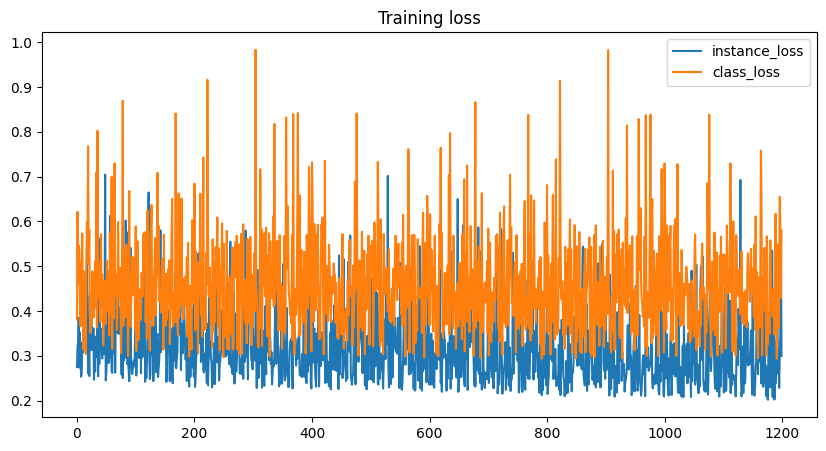

In [ ]:
#@title Training loss plot generation
import matplotlib.pyplot as plt
_instance_loss = [loss.cpu().detach().numpy().item() for loss in instance_loss]
_class_loss = [loss.cpu().detach().numpy().item() for loss in class_loss]
plt.figure(figsize=(10, 5))
plt.title("Training loss")
plt.plot(_instance_loss, label="instance_loss")
plt.plot(_class_loss, label="class_loss")
plt.legend()
plt.show()

## Run the code with your newly trained model
If you have just trained your model with the code above, use the block below to run it.

In [ ]:
#@title Set up the pipeline
from diffusers import DPMSolverMultistepScheduler

pipe = StableDiffusionPipeline.from_pretrained(
    args.output_dir,
    scheduler = DPMSolverMultistepScheduler.from_pretrained(args.output_dir, subfolder="scheduler"),
    torch_dtype=torch.float16,
).to("cuda")



In [ ]:
#@title [Optional] Set up the pipeline using pre-trained multi-objects DreamBooth

#Alternatively, if you don't have the compute power to train, we have uploaded our pre-trained multi-object dreambooth model trained 900 iterations so you can use off-the-shelf

#pipe = DiffusionPipeline.from_pretrained("FanjiaYan/CS182-DreamBooth-2-Object").to("cuda")

# Get Generated Images for Prior

  0%|          | 0/25 [00:00<?, ?it/s]

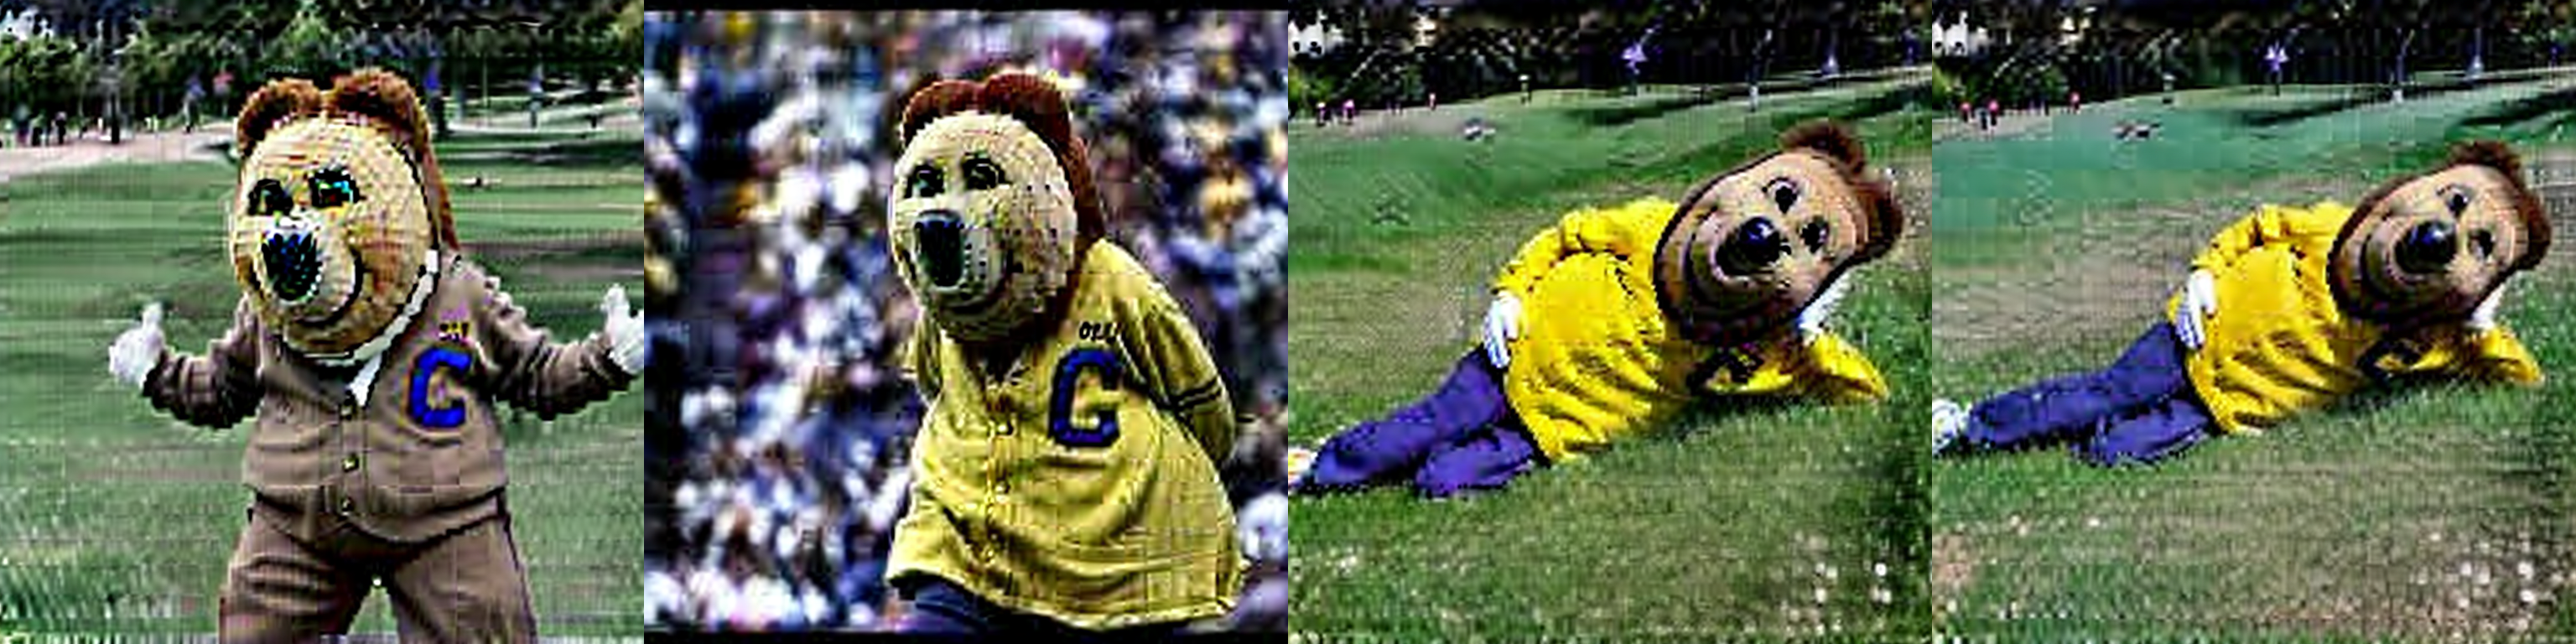

In [ ]:
#@title Run the Stable Diffusion pipeline on Colab
#@markdown Don't forget to use the placeholder token in your prompt

prompt = "Zephon bear" #@param {type:"string"}

num_samples = 4 #@param {type:"number"}
num_rows = 1 #@param {type:"number"}

generated_pres_images = []
for _ in range(num_rows):
    images = pipeline(prompt, num_images_per_prompt=num_samples, num_inference_steps=25, guidance_scale=9).images
    generated_pres_images.extend(images)

grid = image_grid(generated_pres_images, num_rows, num_samples)
grid

# Evaluate Model

We evaluate model by three metrics, DINO, Diversity, and Prior Perservation.

- Prior Preservation calculates the average the cosine similarity of the entire images compare to the pre-trained Stable Diffusion Model.

- DINO calculates the cosine similarity between the original input images and the Dreambooth generated images with the same instance pormpt.

- Diversity calculates the variance of a set of Dreambooth generated images of instance prompt based on the image embedding.


Our result is below:


In [ ]:
import os
from PIL import Image
import torch
from transformers import AutoImageProcessor, AutoModel
from PIL import Image
import os
from sklearn.metrics.pairwise import cosine_similarity
import numpy as np
# Load the processor and model
processor = AutoImageProcessor.from_pretrained('facebook/dinov2-base')
model = AutoModel.from_pretrained('facebook/dinov2-base')


def evaluate_model(pipe):
  prompt = "Therewith bear"

  num_samples = 4
  num_rows = 1

  all_images = []
  for _ in range(num_rows):
      images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=25, guidance_scale=9).images
      all_images.extend(images)
  # Directory where you want to save images
  save_dir = '/content/generated_subject'
  os.makedirs(save_dir, exist_ok=True)
  # Save each image
  for idx, img in enumerate(all_images):
      img.save(os.path.join(save_dir, f'image_{idx}.png'))


  prompt = "bear"

  num_samples = 4
  num_rows = 1
  generated_pres_images = []
  for _ in range(num_rows):
      images = pipe(prompt, num_images_per_prompt=num_samples, num_inference_steps=25, guidance_scale=9).images
      generated_pres_images.extend(images)

  # Directory where you want to save images
  save_dir = '/content/generated_pres_images'
  os.makedirs(save_dir, exist_ok=True)
  # Save each image
  for idx, img in enumerate(generated_pres_images):
      img.save(os.path.join(save_dir, f'image_{idx}.png'))

  def get_DINO_embeddings(directory):
    embeddings = []

    # Iterate over each file in the directory
    for filename in os.listdir(directory):
        if filename.lower().endswith(('.png', '.jpg', '.jpeg', '.tiff', '.bmp', '.gif')):
            file_path = os.path.join(directory, filename)
            image = Image.open(file_path)

            # Process the image
            inputs = processor(images=image, return_tensors="pt")
            outputs = model(**inputs)
            last_hidden_states = outputs[0]
            embeddings.append(last_hidden_states)
    flat = [e.view(-1).detach().numpy() for e in embeddings]
    embeddings = np.stack(flat)
    return embeddings

  generated_subject_embeddings = get_DINO_embeddings("generated_subject")
  real_subject_embeddings = get_DINO_embeddings("my_concept")
  prior_class_embeddings = get_DINO_embeddings("class_images")
  generated_class_embeddings = get_DINO_embeddings("generated_pres_images")

  #Prior Preservation
  similarities = cosine_similarity(prior_class_embeddings, generated_class_embeddings)
  prior_preservation = np.mean(similarities)
  #print("Prior Preservation:", prior_preservation)

  #Diversity
  diversity = np.var(generated_subject_embeddings)
  #print("Diversity:", diversity)

  #Standard DINO
  # Compute pairwise cosine similarity
  reconstruction = cosine_similarity(generated_subject_embeddings, real_subject_embeddings)

  # Calculate the mean similarity
  standard_dino = np.mean(reconstruction)

  #print("DINO (Comparison between actual and generated images):", standard_dino)

  return {"Prior Preservation": prior_preservation, "Diversity": diversity, "Standard DINO": standard_dino}



In [ ]:
evaluate_model(pipe)

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/25 [00:00<?, ?it/s]

{'Prior Preservation': 0.20847611,
 'Diversity': 2.9756768,
 'Standard DINO': 0.20825258}

In [ ]:
torch.cuda.empty_cache()

text_encoder.to("cpu")
vae.to("cpu")
unet.to("cpu")
pipe.to("cpu")

del text_encoder
del vae
del unet
del tokenizer
del pipe
torch.cuda.empty_cache()

gc.collect()

# Hyper Parameter Search

In [ ]:
from argparse import Namespace
import accelerate
from accelerate.utils import set_seed
from diffusers import DPMSolverMultistepScheduler


##### ENTER VALUE TO BE TESTED
hyper_parameter_values = [1e-4, 5e-4, 1e-3, 5e-3, 1e-2]
###############




diversity = []
prior_preservation = []
standard_dino = []

instance_losses = []
class_losses = []
for hyper_parameter in hyper_parameter_values:

  #### Re-download model to fine tune ######

  text_encoder = CLIPTextModel.from_pretrained(
    pretrained_model_name_or_path, subfolder="text_encoder"
  ).to("cuda")
  vae = AutoencoderKL.from_pretrained(
      pretrained_model_name_or_path, subfolder="vae"
  ).to("cuda")
  unet = UNet2DConditionModel.from_pretrained(
      pretrained_model_name_or_path, subfolder="unet"
  ).to("cuda")
  tokenizer = CLIPTokenizer.from_pretrained(
      pretrained_model_name_or_path,
      subfolder="tokenizer",
  )




  ##############

  ##SET HYPERPARAMETERS ####################
  args = Namespace( ### REPLACE EXPERIMENTAL PARAMETER WITH 'hyper_parameter'
      pretrained_model_name_or_path=pretrained_model_name_or_path,
      resolution=vae.sample_size,
      center_crop=True,
      train_text_encoder=False,
      instance_data_dir=save_path,
      instance_prompt=instance_prompt,
      learning_rate=hyper_parameter,
      max_train_steps=200,#300
      save_steps=10000,
      train_batch_size=1, # set to 1 if using prior preservation
      gradient_accumulation_steps=2,
      max_grad_norm=1.0,
      mixed_precision="fp16", # set to "fp16" for mixed-precision training.
      gradient_checkpointing=True, # set this to True to lower the memory usage.
      use_8bit_adam=True, # use 8bit optimizer from bitsandbytes
      seed=3434554,
      with_prior_preservation=prior_preservation,
      prior_loss_weight=prior_loss_weight,
      sample_batch_size=2,
      class_data_dir=prior_preservation_class_folder,
      class_prompt=prior_preservation_class_prompt,
      num_class_images=num_class_images,
      lr_scheduler="constant",
      lr_warmup_steps=100,
      output_dir="dreambooth-concept",
  )
  #####################


  #####FINETUNE MODEL #################
  instance_loss = []
  class_loss = []
  accelerate.notebook_launcher(training_function, args=(text_encoder, vae, unet))
  for param in itertools.chain(unet.parameters(), text_encoder.parameters()):
    if param.grad is not None:
      del param.grad  # free some memory
    torch.cuda.empty_cache()

  instance_losses.append(instance_loss.copy())
  class_losses.append(class_loss.copy())

  ######################################

  ##########GET PIPE ###################
  try:
    pipe
  except NameError:
      pipe = StableDiffusionPipeline.from_pretrained(
          args.output_dir,
          scheduler = DPMSolverMultistepScheduler.from_pretrained(args.output_dir, subfolder="scheduler"),
          torch_dtype=torch.float16,
      ).to("cuda")
  ######################################

  metrics = evaluate_model(pipe)
  diversity.append(metrics["Diversity"])
  prior_preservation.append(metrics["Prior Preservation"])
  standard_dino.append(metrics["Standard DINO"])

  ##### Clear up memory ##########
  torch.cuda.empty_cache()

  text_encoder.to("cpu")
  vae.to("cpu")
  unet.to("cpu")
  pipe.to("cpu")

  del text_encoder
  del vae
  del unet
  del tokenizer
  del pipe
  torch.cuda.empty_cache()

  gc.collect()
  ####################

<ipython-input-33-fd5e2ca1aff8>:46: FutureWarning: Accessing config attribute `sample_size` directly via 'AutoencoderKL' object attribute is deprecated. Please access 'sample_size' over 'AutoencoderKL's config object instead, e.g. 'unet.config.sample_size'.
  resolution=vae.sample_size,
/usr/local/lib/python3.10/dist-packages/diffusers/configuration_utils.py:240: FutureWarning: It is deprecated to pass a pretrained model name or path to `from_config`.If you were trying to load a scheduler, please use <class 'diffusers.schedulers.scheduling_ddpm.DDPMScheduler'>.from_pretrained(...) instead. Otherwise, please make sure to pass a configuration dictionary instead. This functionality will be removed in v1.0.0.
  deprecate("config-passed-as-path", "1.0.0", deprecation_message, standard_warn=False)


Launching training on one GPU.


  0%|          | 0/200 [00:00<?, ?it/s]

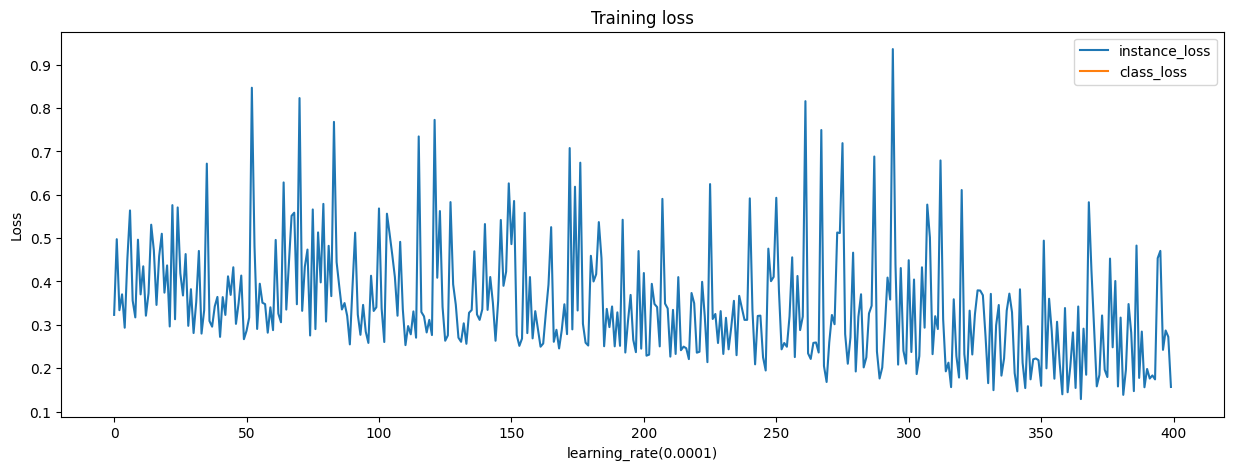

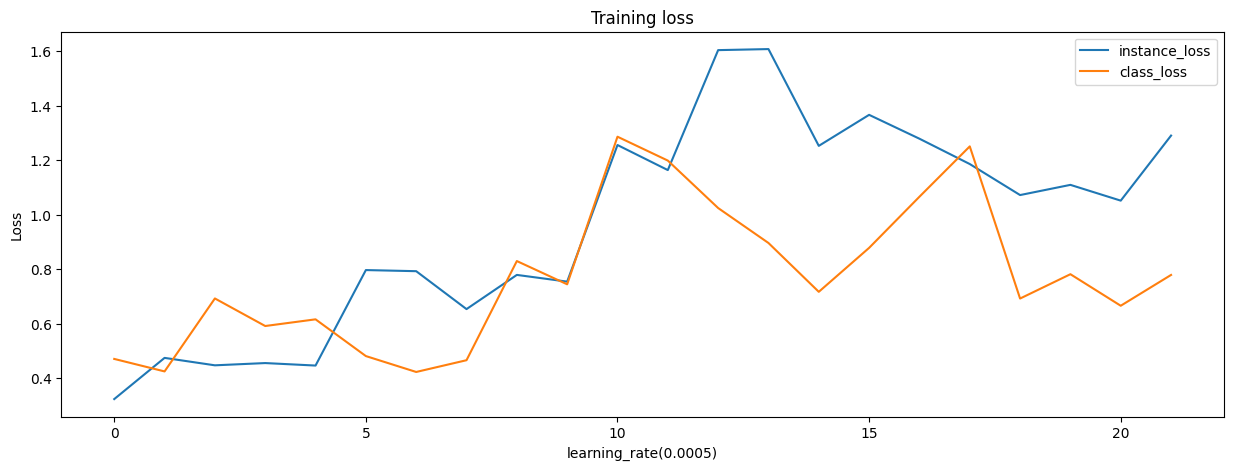

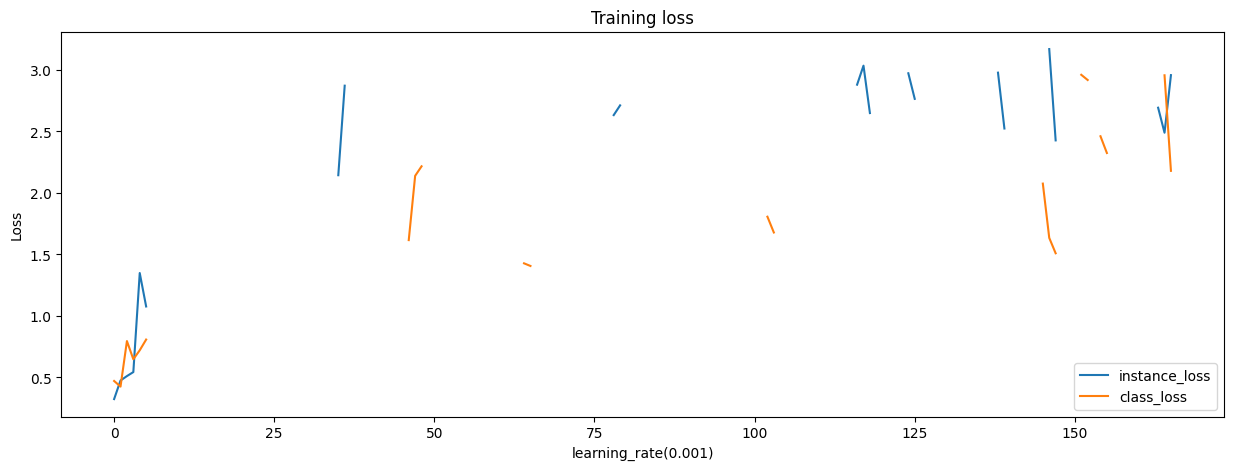

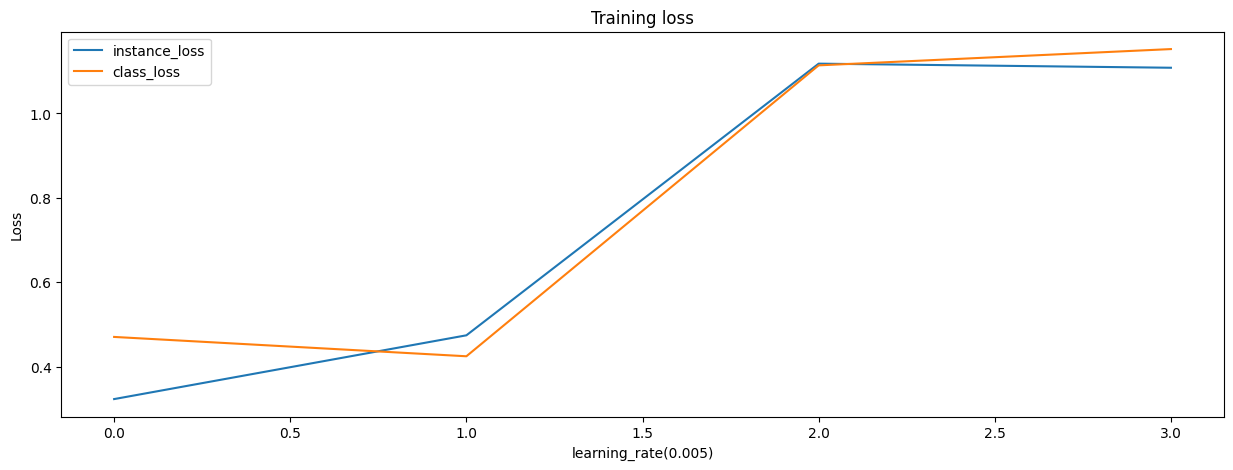

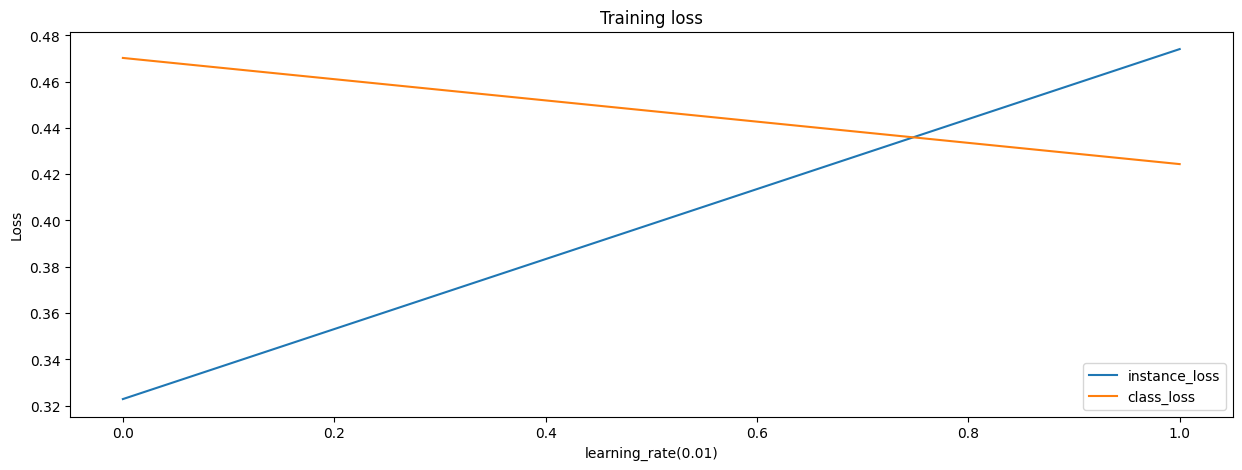

In [ ]:
##Get Loss Curves

import matplotlib.pyplot as plt
hyper_parameter_name = "learning_rate"

def plot_loss(instance_loss, class_loss, hyper_parameter_value, hyper_parameter_name):
  _instance_loss = [loss.cpu().detach().numpy().item() for loss in instance_loss]
  _class_loss = [loss.cpu().detach().numpy().item() for loss in class_loss]
  plt.figure(figsize=(15, 5))
  plt.title("Training loss")
  plt.xlabel(hyper_parameter_name+f"({hyper_parameter_value})")
  plt.ylabel("Loss")
  plt.plot(_instance_loss, label="instance_loss")
  plt.plot(_class_loss, label="class_loss")
  plt.legend()
  plt.show()

for i, hyper_parameter_value in enumerate(hyper_parameter_values):
  plot_loss(instance_losses[i], class_losses[i], hyper_parameter_value, hyper_parameter_name)


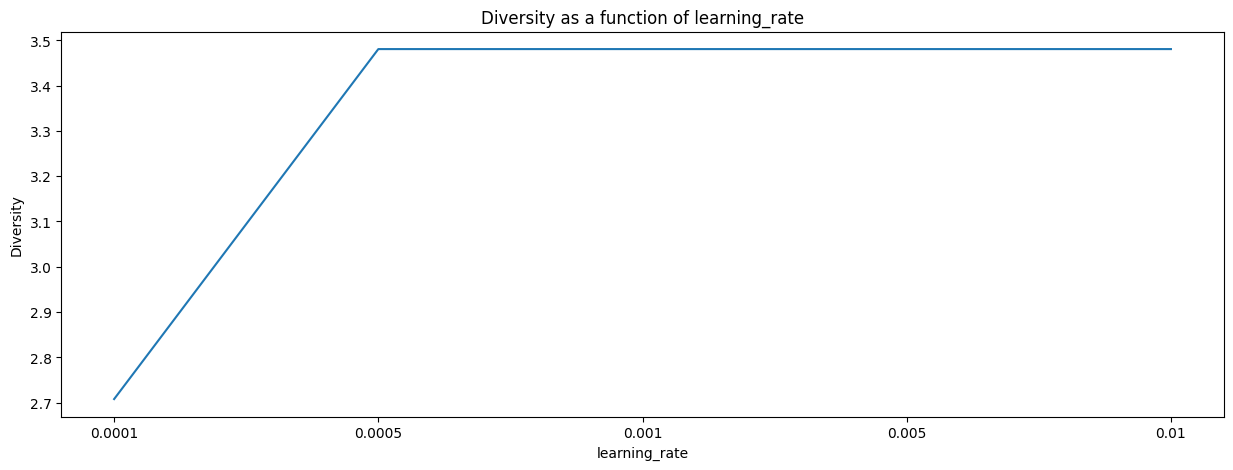

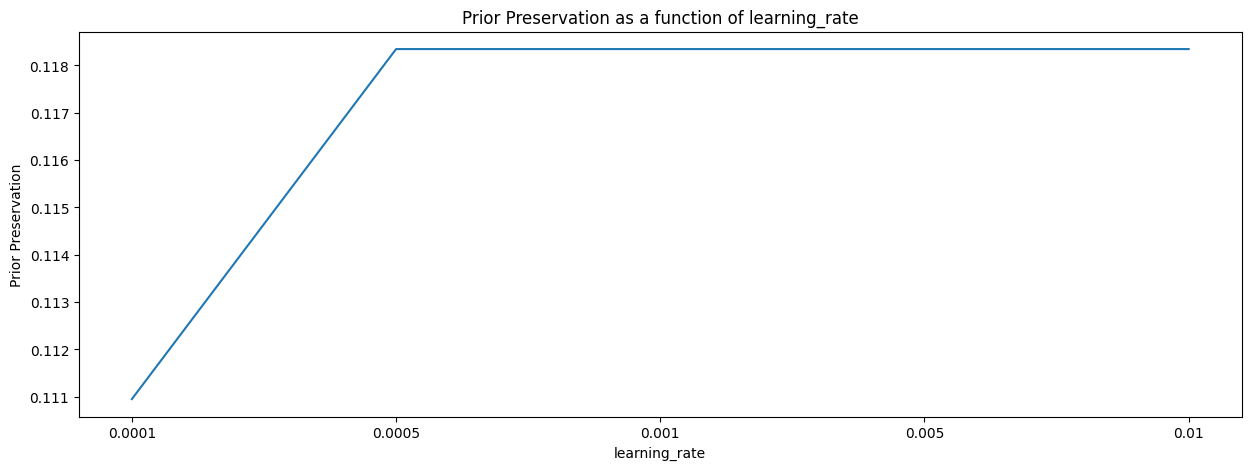

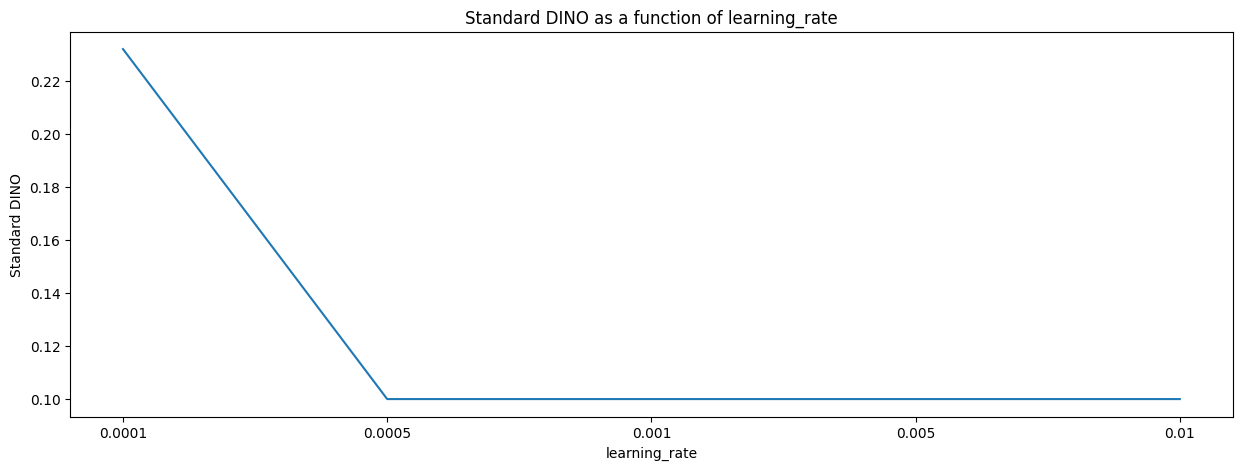

In [ ]:
## Plot Metrics over Hyper Parameter Settings
def plot_metrics(diversity, prior_preservation, standard_dino, hyper_parameter_values, hyper_parameter_name):
  metric_names = ["Diversity", "Prior Preservation", "Standard DINO"]
  metrics = [diversity, prior_preservation, standard_dino]

  for i, metric in enumerate(metrics):
    x_indices = np.arange(len(hyper_parameter_values))
    value_string = [str(value) for value in hyper_parameter_values]
    plt.figure(figsize=(15, 5))
    plt.title(f"{metric_names[i]} as a function of {hyper_parameter_name}")
    plt.xlabel(hyper_parameter_name)
    plt.ylabel(metric_names[i])
    plt.plot(x_indices, metric)
    plt.xticks(x_indices, value_string)

    plt.show()

plot_metrics(diversity, prior_preservation, standard_dino, hyper_parameter_values, hyper_parameter_name)